**Table of contents**<a id='toc0_'></a>    
- [import Data](#toc1_1_)    
  - [Get The Data Ready](#toc1_2_)    
  - [Get The NN Model Ready](#toc1_3_)    
  - [Setup The Net and Hyperparameters](#toc1_4_)    
  - [Check for network errors in network class](#toc1_5_)    
  - [Run The Model and Show the Results](#toc1_6_)    
  - [Now we should see where the model made mistakes?](#toc1_7_)    
  - [Save and Load the Model:](#toc1_8_)    
  - [Get the Confusion Matrix](#toc1_9_)    
  - [Get Other Metrics](#toc1_10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
## Import Standard Libs
import time
import sys
import numpy as np
import copy
##
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
##
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torchinfo import summary


##
from sklearn.model_selection import train_test_split


In [2]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
## For this small model cpu is faster!
device = 'cpu'

cuda:0


In [ ]:

print(torch.cuda.is_available())
torch.cuda.get_arch_list()

True


['sm_50',
 'sm_60',
 'sm_61',
 'sm_70',
 'sm_75',
 'sm_80',
 'sm_86',
 'sm_37',
 'sm_90',
 'compute_37']

## <a id='toc1_1_'></a>[import Data](#toc0_)


In [4]:

data = np.loadtxt(open('E:/0000pdf0000/School_Master/z_PythonCodes/Dataset/MNIST/mnist_train.csv','rb'), delimiter=',')
test_data  = np.loadtxt(open('E:/0000pdf0000/School_Master/z_PythonCodes/Dataset/MNIST/mnist_test.csv','rb'), delimiter=',')

In [5]:
data.shape

(60000, 785)

In [6]:
labels = data[:,0]
# train_labels = train_labels[:,None]
data   = data[:,1:]


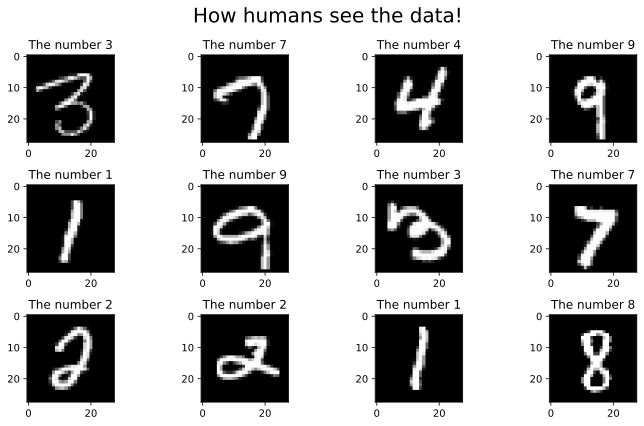

In [ ]:
import matplotlib
plt.style.use("default")

fig,axs = plt.subplots(3,4,figsize=(10,6))


for ax in axs.flatten():
    RandImg2Show = np.random.randint(low=0,high=max(data.shape))
    img = np.reshape(data[RandImg2Show,:],(28,28))
    ax.imshow(img,cmap='gray')
    ax.set_title('The number %i'%labels[RandImg2Show])
plt.suptitle('How humans see the data!',fontsize=20)

plt.tight_layout(rect=[0,0,1,1])
plt.show()

## <a id='toc1_2_'></a>[Get The Data Ready](#toc0_)

In [8]:
# @title Normalize Data
dataNorm = data/np.max(data)

In [9]:
#@title Create DataLoaders

torch.manual_seed(4)
batchSize = 32
Data_tesor    = torch.tensor(dataNorm).float()
Labels_tensor = torch.tensor(labels).long()#.short() must be tried !!! 

(trainData,devData,trainLabels,devLabels) = train_test_split(Data_tesor,Labels_tensor,test_size=0.1,random_state=4)

trainDS = TensorDataset(trainData,trainLabels)
devDS   = TensorDataset(devData,devLabels)

trainDL = DataLoader(trainDS,batch_size= batchSize ,shuffle=True,drop_last=True)
devDL   = DataLoader(devDS,batch_size=devDS.tensors[0].shape[0],shuffle=True) 


In [ ]:
## Confirm the data Ranges

print('Training data range is %g to %g'%(torch.min(trainDL.dataset.tensors[0]),torch.max(trainDL.dataset.tensors[0])))
print('Test data range is %g to %g'%(torch.min(devDL.dataset.tensors[0]),torch.max(devDL.dataset.tensors[0])))


Training data range is 0 to 1
Test data range is 0 to 1


## <a id='toc1_3_'></a>[Get The NN Model Ready](#toc0_)

In [ ]:
#@title Create Custome FFN Model:
 
class FFN_Custom(nn.Module):
  def __init__(self,n_UnitsPerLayer,AF_perLayer,DropoutRate = 0.0,BatchNormActivate =False):
    super().__init__()
    ## NN Architecture
    self.dropoutRate   = DropoutRate 
    self.BNActivate    = BatchNormActivate 
    self.AFs           = nn.ModuleDict()
    self.Layers        = nn.ModuleDict()
    self.nHiddenLayers = len(n_UnitsPerLayer)-3 # The number of Hidden layers. Input and outputs are excluded

    ## input layer
    self.Layers['input'] = nn.Linear(*n_UnitsPerLayer[0:1+1])
    self.AFs['input']    = getattr(torch.nn,AF_perLayer[0])()
    ## Hidden layers
    for i in range(self.nHiddenLayers):
      if BatchNormActivate:
        self.Layers[f'BN{i}'] = nn.BatchNorm1d(n_UnitsPerLayer[i+1])
      self.Layers[f'hidden{i}'] = nn.Linear(*n_UnitsPerLayer[i+1:i+3])
      self.AFs[f'hidden{i}'] = getattr(torch.nn, AF_perLayer[i+1])()

    self.Layers['output'] = nn.Linear(*n_UnitsPerLayer[-2:])


  ## Forward pass function
  def forward(self,x):
    x = self.AFs['input'](self.Layers['input'](x))
    for i in range(self.nHiddenLayers):
      if self.BNActivate:
        x = self.Layers[f'BN{i}'](x)
      x = self.AFs[f'hidden{i}'](self.Layers[f'hidden{i}'](x))
      
      x = F.dropout(x,p=self.dropoutRate,training=self.training) # You can comment this if you dont want to have dropout or just leave dropoutrate =0 (the default value!)

    x = self.Layers['output'](x)

    return torch.log_softmax(x,axis = 1)
  
  
  def NamedParamInit(self,Method ='xavier_normal_'):
    
    # for name,param in self.named_parameters():
    #   getattr(nn.init,Method)(param.data)
    for name, param in self.named_parameters():
          if 'weight' in name:
              getattr(nn.init, Method)(param.data)
          # elif 'bias' in name:
          #     nn.init.constant_(param.data, 0.0)
  

## <a id='toc1_4_'></a>[Setup The Net and Hyperparameters](#toc0_)

In [ ]:
class MnistCNN(nn.Module):
    def __init__(self,printInfo =False):
        super().__init__()
        self.printing = printInfo
        # The first layer gets a 28*28 input image!
        self.conv1 = nn.Conv2d(1,10,kernel_size=5,stride=1,padding=1)# It has maxpool
        # conv1 layer output units are: floor((28+2-5)/1)+1 = 26 + maxpool -> 26/2 = 13 
        # The second layer gets a 13*13 input image!
        self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)# It has maxpool
        # conv2 layer output units are: floor((13+2-5)/1)+1 = 11  + maxpool -> 11/2 = 5  
        fc1size = np.floor( (5+2*0-1)/1 ) + 1 # = 5
        fc1size = int(20*(fc1size**2)) # = 500
        self.FFNInputSize = fc1size
        self.fc1 = nn.Linear(fc1size,50)
        self.outLayer = nn.Linear(50,10) 
    def forward(self,x):
        print(f'Input shape = {x.shape}') if self.printing else None
        # Conv1 -> MaxPool -> ReLU
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size= 2))
        print(f'After conv/pool 1 shape = {x.shape}') if self.printing else None
        # Conv2 -> MaxPool -> ReLU
        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size= 2))
        print(f'After conv/pool 2 shape = {x.shape}') if self.printing else None
        
        # nUnits  = x.shape.numel()/x.shape[0]
        # print(nUnits,self.FFNInputSize) if self.printing else None
        
        x = x.view(-1,self.FFNInputSize)
        if self.printing: print(f'Vectorized: {x.shape}')
        x = F.relu(self.fc1(x))
        if self.printing: print(f'Layer fc1: {x.shape}')
        x = self.outLayer(x)
        if self.printing: print(f'Out Layer: {x.shape}')
        return x


In [ ]:

def SetupNNModel(LearningRate = 0.01,DropoutRate = 0.0,BNActivate=False):
    
    LayerUnits  = [784,64,32,32,10]
    AFs         = ['ReLU','ReLU','ReLU']
    net = FFN_Custom(n_UnitsPerLayer=LayerUnits,AF_perLayer=AFs,DropoutRate=DropoutRate,BatchNormActivate=BNActivate)
    print(net)
    print(summary(net))

    LossFun   = nn.NLLLoss() #This the log of softmax function! 
    optimizer = torch.optim.SGD(net.parameters(),lr= LearningRate)
    return net,LossFun,optimizer

## <a id='toc1_5_'></a>[Check for network errors in network class](#toc0_)

In [14]:
(MnistNet,LossFun,optimizer) = SetupNNModel()
x,y  = next(iter(trainDL))
yHat = MnistNet(x)
loss = LossFun(yHat,y)
print(loss)


FFN_Custom(
  (AFs): ModuleDict(
    (input): ReLU()
    (hidden0): ReLU()
    (hidden1): ReLU()
  )
  (Layers): ModuleDict(
    (input): Linear(in_features=784, out_features=64, bias=True)
    (hidden0): Linear(in_features=64, out_features=32, bias=True)
    (hidden1): Linear(in_features=32, out_features=32, bias=True)
    (output): Linear(in_features=32, out_features=10, bias=True)
  )
)
Layer (type:depth-idx)                   Param #
FFN_Custom                               --
├─ModuleDict: 1-1                        --
│    └─ReLU: 2-1                         --
│    └─ReLU: 2-2                         --
│    └─ReLU: 2-3                         --
├─ModuleDict: 1-2                        --
│    └─Linear: 2-4                       50,240
│    └─Linear: 2-5                       2,080
│    └─Linear: 2-6                       1,056
│    └─Linear: 2-7                       330
Total params: 53,706
Trainable params: 53,706
Non-trainable params: 0
tensor(2.3410, grad_fn=<NllLossBackwa

In [26]:
MnistNet.Layers['input'].weight.requires_grad = False


MnistNet.Layers['input'].weight.requires_grad

Parameter containing:
tensor([ 0.0209,  0.0135,  0.0021,  0.0228,  0.0217, -0.0211,  0.0021, -0.0216,
         0.0062,  0.0076,  0.0169,  0.0201, -0.0029,  0.0183, -0.0071, -0.0086,
        -0.0241, -0.0323,  0.0111,  0.0178, -0.0189, -0.0138, -0.0095,  0.0011,
        -0.0175,  0.0289, -0.0243, -0.0216,  0.0287, -0.0043,  0.0355, -0.0221,
        -0.0242,  0.0007,  0.0046,  0.0196, -0.0064, -0.0150, -0.0288, -0.0056,
        -0.0325,  0.0085,  0.0079,  0.0173, -0.0336,  0.0205, -0.0154, -0.0028,
        -0.0229,  0.0221,  0.0249,  0.0287,  0.0073,  0.0009,  0.0193,  0.0269,
        -0.0350, -0.0219,  0.0023, -0.0268, -0.0309, -0.0075, -0.0007,  0.0089],
       requires_grad=True)

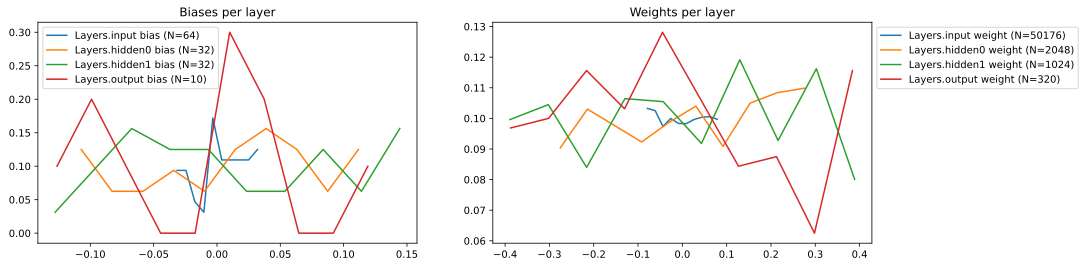

In [66]:
MnistNet.NamedParamInit(Method='kaiming_uniform_')
# nn.init.kaiming_uniform_

fig,ax = plt.subplots(1,2,figsize=(15,4))

for p in MnistNet.named_parameters():

  # get the data and compute their histogram
  thesedata = p[1].data.numpy().flatten()
  y,x = np.histogram(thesedata,10)

  # for the bias
  if 'bias' in p[0]:
    ax[0].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s bias (N=%g)'%(p[0][:-5],len(thesedata)))

  # for the weights
  elif 'weight' in p[0]:
    ax[1].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s weight (N=%g)'%(p[0][:-7],len(thesedata)))



ax[0].set_title('Biases per layer')
ax[0].legend()
ax[1].set_title('Weights per layer')
ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')
plt.show()

In [32]:
MnistNet.Layers

ModuleDict(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (hidden0): Linear(in_features=64, out_features=32, bias=True)
  (hidden1): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

As we can see there are no issues with the architecture so far so we are ready to create the training Loop


In [33]:
a =torch.rand((5,10),dtype=torch.float64)
print(a)
torch.argmax(a,axis = 1)


tensor([[0.5305, 0.7529, 0.5530, 0.8720, 0.8459, 0.7377, 0.8612, 0.8198, 0.9686,
         0.9780],
        [0.3356, 0.9501, 0.0955, 0.8905, 0.9976, 0.9850, 0.9326, 0.1400, 0.6329,
         0.6405],
        [0.5959, 0.8655, 0.2298, 0.7750, 0.7143, 0.0727, 0.6919, 0.9516, 0.2412,
         0.0663],
        [0.7192, 0.4232, 0.5908, 0.8723, 0.9930, 0.6272, 0.2232, 0.7309, 0.7365,
         0.3059],
        [0.4579, 0.7942, 0.9828, 0.6940, 0.3901, 0.7167, 0.3319, 0.7372, 0.3983,
         0.1348]], dtype=torch.float64)


tensor([9, 4, 7, 4, 2])

In [ ]:
def Function2TrainTheModel(EpochNum = 60 , LearningRate = 0.01, device ='cpu',
                           WantNamedParamChanges = False):
    """
    returns :
    (net,SaveInfoDict)
    """
    print(device)
    #initialize a dictionary for the best model
    theBestModel = {'Accuracy':0.0, 'BestNet_stateDict':None, 'BestAccEpoch':int()}
    
    ## Setup a new model
    (net,LossFun,optimizer) = SetupNNModel(LearningRate= LearningRate,BNActivate=True)
    
    # initialize weight change matrices
    if WantNamedParamChanges:
        weightChange = np.zeros((EpochNum,net.nHiddenLayers+2))
        weightConds  = np.zeros((EpochNum,net.nHiddenLayers+2))

    ## Initiallize Losses and saveinfo
    SaveInfo = {'EpochLoss':np.zeros((EpochNum,1),dtype=np.float32),
                'TrainAcc' :[],
                'TestAcc'  :[],
                'TrainTime': float(),
                'WeightChange':weightChange,
                'weightConds' :weightConds}
    i = 1 # remove this 
    SaveInfo['TrainTime'] = time.time()
    net.to(device)

    net.train()
    for epochi in range(EpochNum):
        BatchLoss = []
        BatchAcc  = []
        ## Store the weights for each layer, we need this to compute weight change matrices
        if WantNamedParamChanges:
            preW = []
            # preB = []
            for p in net.named_parameters():
                if 'weight' in p[0]:
                    preW.append( copy.deepcopy(p[1].data.numpy()) )
                # if 'bias' in p[0]:
                #     preB.append( copy.deepcopy(p[1].data.numpy()) )
            
        
        ## Batch loop Starts here
        for X,y in trainDL:
            X = X.to(device)
            y = y.to(device)
            ## Forward Pass
            yHat = net(X)
            loss = LossFun(yHat,y)
            ## Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## Collecting Batch History 
            BatchLoss.append(loss.item())
            yHat = yHat.cpu()
            y    = y.cpu()
            matches = torch.argmax(yHat,axis = 1) == y # Matches is a tensor of boolians
            matchesNumeric = matches.float()
            BatchAcc.append(100* torch.mean(matchesNumeric))
        ## Batch loop is over here 
                
        ## Get the Saveinfo per epoch:
        X,y = next(iter(devDL))
        X = X.to(device)
        # y = y.to(device)
        net.eval()
        with torch.no_grad():
            yHat = net(X)
        yHat = yHat.cpu()
        SaveInfo['TestAcc'].append(100* (torch.mean((torch.argmax(yHat,axis = 1) == y).float()).numpy()) )
        ## Capture the best Model
        if SaveInfo['TestAcc'][-1] > theBestModel['Accuracy']:
            theBestModel['Accuracy'] = SaveInfo['TestAcc'][-1]
            theBestModel['BestNet_stateDict'] = copy.deepcopy(net.state_dict())
            theBestModel['BestAccEpoch'] = epochi
        SaveInfo['EpochLoss'][epochi] = np.mean(BatchLoss)
        SaveInfo['TrainAcc'].append(np.mean(BatchAcc))

        # finally, get the post-learning state of the weights
        if WantNamedParamChanges:
            for (i,p) in enumerate(net.named_parameters()):
                if 'weight' in p[0]:
                    # condition number
                    weightConds[epochi,int(i/2)]  = np.linalg.cond(p[1].data)

                    # Frobenius norm of the weight change from pre-learning
                    weightChange[epochi,int(i/2)] = np.linalg.norm( preW[int(i/2)]-p[1].data.numpy(), ord='fro')

        SaveInfo['weightConds']  = weightConds
        SaveInfo['WeightChange'] = weightChange
        
        msg = f'Finished iteration {epochi+1}/{EpochNum}'
        sys.stdout.write('\r' + msg)
    SaveInfo['TrainTime'] = time.time() - SaveInfo['TrainTime']
    return net,SaveInfo,theBestModel

## <a id='toc1_6_'></a>[Run The Model and Show the Results](#toc0_)

In [41]:
net,History,BestModelInfo = Function2TrainTheModel(EpochNum=5,LearningRate=0.01,device=device)



cuda:0
FFN_Custom(
  (AFs): ModuleDict(
    (input): ReLU()
    (hidden0): ReLU()
    (hidden1): ReLU()
  )
  (Layers): ModuleDict(
    (input): Linear(in_features=784, out_features=64, bias=True)
    (BN0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden0): Linear(in_features=64, out_features=32, bias=True)
    (BN1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden1): Linear(in_features=32, out_features=32, bias=True)
    (output): Linear(in_features=32, out_features=10, bias=True)
  )
)
Layer (type:depth-idx)                   Param #
FFN_Custom                               --
├─ModuleDict: 1-1                        --
│    └─ReLU: 2-1                         --
│    └─ReLU: 2-2                         --
│    └─ReLU: 2-3                         --
├─ModuleDict: 1-2                        --
│    └─Linear: 2-4                       50,240
│    └─BatchNorm1d: 2-5                  128
│    └─Linea

In [40]:
print(History['TrainTime'])
History['TestAcc'][-1]

55.122403621673584


97.01666831970215

In [42]:
print(History['TrainTime'])
History['TestAcc'][-1]

64.25134825706482


96.5499997138977

In [ ]:
BestModelInfo['BestAccEpoch']


30

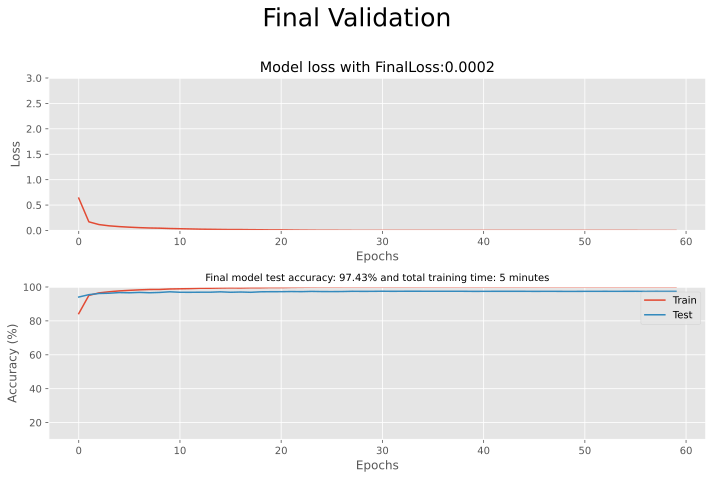

In [ ]:
plt.style.use(plt.style.available[9])
fig,ax = plt.subplots(2,1,figsize=(10,6))

ax[0].plot(History['EpochLoss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title(f'Model loss with FinalLoss:{History["EpochLoss"][-1][0]:0.4f}')

ax[1].plot(History['TrainAcc'],label='Train')
ax[1].plot(History['TestAcc'],label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])

ax[1].set_title(f'Final model test accuracy: {History["TestAcc"][-1]:.2f}% and total training time: {History["TrainTime"]/60:0.0f} minutes',fontsize=10)
ax[1].legend()
fig.tight_layout()
fig.suptitle("Final Validation",y = 1.1,fontsize =25)
plt.show()

## <a id='toc1_7_'></a>[Now we should see where the model made mistakes?](#toc0_)

In [ ]:
X,y  = next(iter(devDL))
net.eval()
with torch.no_grad():
    Predictions = net(X).detach()

ErrorIndex = np.where(torch.max(Predictions,axis=1)[1] != y) [0]

ErrorIndex

array([  10,   18,   84,   91,  152,  238,  257,  298,  302,  332,  360,
        370,  391,  436,  446,  482,  525,  531,  572,  597,  686,  756,
        792,  799,  827,  891,  978, 1114, 1139, 1143, 1239, 1254, 1290,
       1292, 1312, 1411, 1423, 1443, 1535, 1721, 1820, 1918, 1969, 2044,
       2061, 2062, 2135, 2165, 2191, 2252, 2271, 2277, 2309, 2423, 2452,
       2469, 2472, 2486, 2527, 2540, 2594, 2710, 2730, 2777, 2802, 2834,
       2840, 2842, 2847, 2967, 2973, 3013, 3019, 3059, 3089, 3106, 3119,
       3184, 3209, 3210, 3251, 3255, 3278, 3311, 3318, 3398, 3499, 3585,
       3626, 3785, 3803, 3889, 4015, 4017, 4045, 4060, 4092, 4234, 4266,
       4286, 4317, 4326, 4345, 4380, 4400, 4450, 4463, 4499, 4511, 4518,
       4537, 4566, 4695, 4713, 4720, 4748, 4804, 4868, 4903, 4933, 4952,
       5005, 5014, 5030, 5038, 5047, 5079, 5085, 5133, 5162, 5191, 5216,
       5233, 5291, 5353, 5370, 5473, 5574, 5603, 5625, 5649, 5673, 5692,
       5709, 5751, 5755, 5822, 5833, 5880, 5932, 59

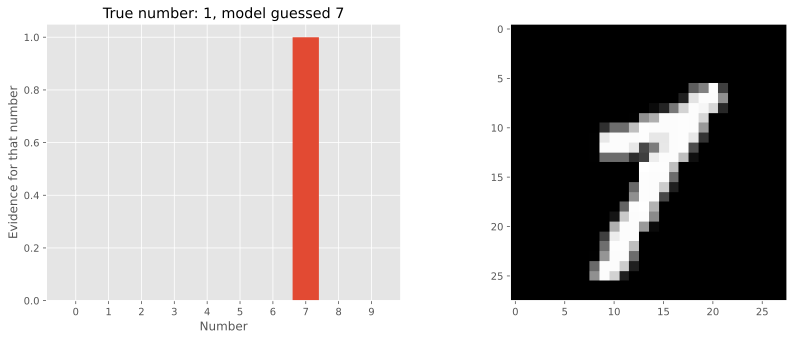

In [ ]:
sample2show = 1

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(Predictions[ErrorIndex[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[ErrorIndex[sample2show]].item(), torch.argmax(Predictions[ErrorIndex[sample2show]]).item() ))
ax[1].imshow( np.reshape(X[ErrorIndex[sample2show],:],(28,28)) ,cmap='gray')
ax[1].grid(False)
plt.show()

## <a id='toc1_8_'></a>[Save and Load the Model:](#toc0_)

In [ ]:
# torch.save(net.state_dict(),'TrainedMNIST.pt')# pt stands for pytorch 


FFN_Custom(
  (AFs): ModuleDict(
    (input): ReLU()
    (hidden0): ReLU()
    (hidden1): ReLU()
  )
  (Layers): ModuleDict(
    (input): Linear(in_features=784, out_features=64, bias=True)
    (BN0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden0): Linear(in_features=64, out_features=32, bias=True)
    (BN1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden1): Linear(in_features=32, out_features=32, bias=True)
    (output): Linear(in_features=32, out_features=10, bias=True)
  )
)
Layer (type:depth-idx)                   Param #
FFN_Custom                               --
├─ModuleDict: 1-1                        --
│    └─ReLU: 2-1                         --
│    └─ReLU: 2-2                         --
│    └─ReLU: 2-3                         --
├─ModuleDict: 1-2                        --
│    └─Linear: 2-4                       50,240
│    └─BatchNorm1d: 2-5                  128
│    └─Linear: 2-6 

<All keys matched successfully>

In [ ]:
net_new = SetupNNModel(BNActivate=True)[0]
net_new.load_state_dict(torch.load('TrainedMNIST.pt'))


FFN_Custom(
  (AFs): ModuleDict(
    (input): ReLU()
    (hidden0): ReLU()
    (hidden1): ReLU()
  )
  (Layers): ModuleDict(
    (input): Linear(in_features=784, out_features=64, bias=True)
    (BN0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden0): Linear(in_features=64, out_features=32, bias=True)
    (BN1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden1): Linear(in_features=32, out_features=32, bias=True)
    (output): Linear(in_features=32, out_features=10, bias=True)
  )
)
Layer (type:depth-idx)                   Param #
FFN_Custom                               --
├─ModuleDict: 1-1                        --
│    └─ReLU: 2-1                         --
│    └─ReLU: 2-2                         --
│    └─ReLU: 2-3                         --
├─ModuleDict: 1-2                        --
│    └─Linear: 2-4                       50,240
│    └─BatchNorm1d: 2-5                  128
│    └─Linear: 2-6 

<All keys matched successfully>

## <a id='toc1_9_'></a>[Get the Confusion Matrix](#toc0_)

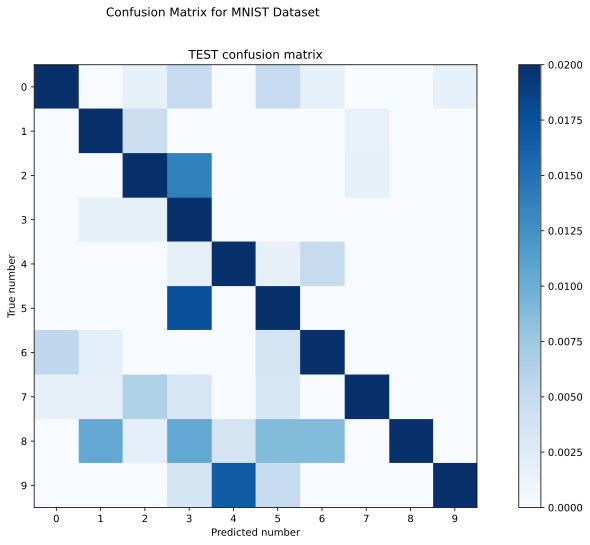

In [ ]:
import sklearn.metrics as skm
X,y  = next(iter(devDL))
net_new.eval()
with torch.no_grad():
    yHat = net_new(X)
    Predictions = torch.argmax(yHat,axis=1)
Predictions.shape
Test_CM = skm.confusion_matrix(y,Predictions , normalize='true')
fig,ax = plt.subplots(1,1,figsize=(15,8))
a = ax.imshow(Test_CM,'Blues',vmax=0.02)
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_title('TEST confusion matrix')
ax.set_xlabel('True number')
ax.set_xlabel('Predicted number')
ax.set_ylabel('True number')


fig.colorbar(a)
fig.suptitle('Confusion Matrix for MNIST Dataset')

plt.show()

## <a id='toc1_10_'></a>[Get Other Metrics](#toc0_)